In [2]:
import importlib
import GNN_module.scripts as scripts #only used for on the fly reloads
import GNN_module.metrics as metrics #only used for on the fly reloads
import GNN_module.plotting as plotting #only used for on the fly reloads
import GNN_module.pertubate as pertubate #only used for on the fly reloads
import torch
import copy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from torch_geometric.nn.models import GAT, GCN
from sklearn.model_selection import ParameterGrid
import numpy as np

from GNN_module.scripts import *
from GNN_module.metrics import *
from GNN_module.plotting import *
from GNN_module.pertubate import *
import torch.nn.functional as F
from carbontracker.tracker import CarbonTracker
import random


In [20]:
#Run this to reload the scripts without restarting the kernel
importlib.reload(scripts)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(pertubate)
from GNN_module.scripts import *
from GNN_module.metrics import *
from GNN_module.plotting import *
from GNN_module.pertubate import *

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


# IMPORTANT: write requirements file and readme after work is done

# Datasets

In [4]:
dataset_cora = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
dataset_citeseer = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
dataset_pubmed = Planetoid(root='data/Planetoid', name='Pubmed', transform=NormalizeFeatures())

In [10]:
data_cora = dataset_cora[0]
data_citeseer = dataset_citeseer[0]
data_pubmed = dataset_pubmed[0]

In [5]:
dataset = dataset_cora
data = dataset[0]  # Get the first graph object.
dataset_statistics(dataset)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


# Model initialising

In [12]:
gat, optimizer_gat = initialize_model_from_sweep(path_to_sweep='sweeps\sweep_results_gat_cora.pkl', dataset=dataset_cora, model_type='GAT')
gatv2, optimizer_gatv2 = initialize_model_from_sweep(path_to_sweep='sweeps\sweep_results_gatv2_cora.pkl', dataset=dataset_cora, model_type='GATv2')

gat_citeseer, optimizer_gat_citeseer = initialize_model_from_sweep(path_to_sweep='sweeps\sweep_results_gat_CiteSeer.pkl', dataset=dataset_citeseer, model_type='GAT')
gatv2_citeseer, optimizer_gatv2_citeseer = initialize_model_from_sweep(path_to_sweep='sweeps\sweep_results_gatv2_CiteSeer.pkl', dataset=dataset_citeseer, model_type='GATv2')

criterion = torch.nn.CrossEntropyLoss()

In [13]:
num_params_gat = count_trainable_parameters(gat_citeseer)
num_params_gatv2 = count_trainable_parameters(gatv2_citeseer)

print(f'Number of trainable parameters in GAT: {num_params_gat}')
print(f'Number of trainable parameters in GATv2: {num_params_gatv2}')

Number of trainable parameters in GAT: 243526
Number of trainable parameters in GATv2: 240342


# Training

In [15]:
num_epochs = 500

## CiteSeer

In [16]:
loss_list_gat_citeseer = train_model(num_epochs, gat_citeseer,data_citeseer, optimizer_gat_citeseer, criterion)
loss_list_gatv2_citeseer = train_model(num_epochs, gatv2_citeseer,data_citeseer, optimizer_gatv2_citeseer, criterion)

Training model...

Training model...0.8280295133590698



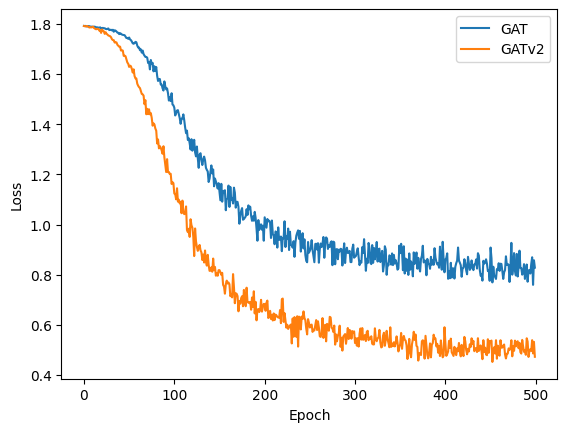

In [17]:
plt.plot(loss_list_gat_citeseer, label='GAT')
plt.plot(loss_list_gatv2_citeseer, label='GATv2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
test_model(data_citeseer.test_mask, gat_citeseer, data_citeseer), test_model(data_citeseer.test_mask, gatv2_citeseer, data_citeseer)

(0.701, 0.703)

## Cora

In [9]:
loss_list_gat = train_model(num_epochs, gat, data_cora, optimizer_gat, criterion)
loss_list_gatv2 = train_model(num_epochs, gatv2, data_cora, optimizer_gatv2, criterion)

Training model...

Training model...0.43712085485458374



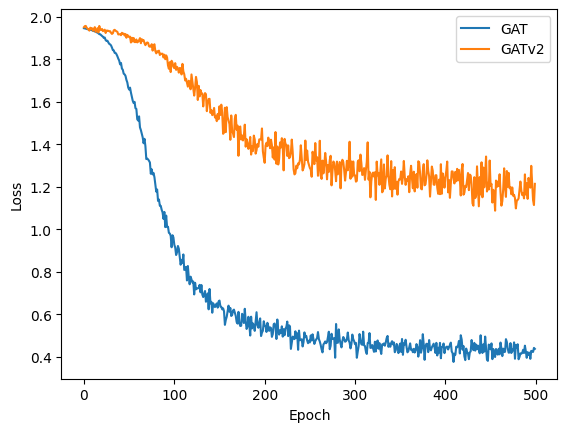

In [10]:
plt.plot(loss_list_gat, label='GAT')
plt.plot(loss_list_gatv2, label='GATv2')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
test_model(data.test_mask, gat, data), test_model(data.test_mask, gatv2, data)

(0.795, 0.828)

# Research ideas





## Robustness of GATs to Adversarial Attacks
### Research Question: 
How robust are Graph Attention Networks to adversarial attacks compared to other GNN architectures?
### Hypothesis:
 GATs, due to their ability to focus on important nodes via attention, are more robust against adversarial attacks than non-attention-based GNNs like Graph Convolutional Networks (GCNs).
### Novelty:
You can simulate simple adversarial attacks (e.g., perturbing node features or edges) and compare the robustness of GATs vs. GCNs or other GNN architectures.



## Transfer Learning with Graph Attention Networks
### Research Question:
Can GATs trained on one type of graph (e.g., a citation network) be effectively transferred to another type (e.g., a social network) using transfer learning?
### Hypothesis:
GATs are more effective for transfer learning between graphs of similar structures (e.g., citation networks to co-authorship networks) compared to graphs with significantly different structures (e.g., citation to biological networks).
### Novelty:
Explore transfer learning in GNNs, specifically GATs, which is less explored. You can train on one graph type, fine-tune on another, and measure performance gains.


# Robustness

We can test robustness to disruptions in the data in a number of ways:

- Adding feature noise (Gaussian noise to each feature or noise acroos entire dataset)
- Adding non existing edges
- Removing edges

## Feature noise

### CiteSeer

In [21]:
n = 10
scale, test_gat_citeseer = do_n_tests(test_feature_noise_robustness, gat_citeseer, data_citeseer, n=n, global_noise=False)
scale, test_gatv2_citeseer = do_n_tests(test_feature_noise_robustness, gatv2_citeseer, data_citeseer, n=n, global_noise=False)

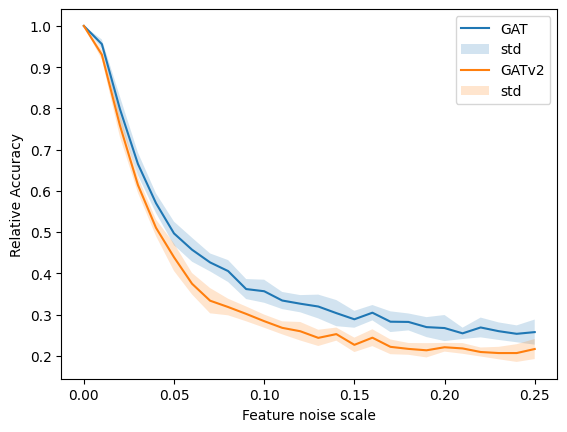

In [22]:
test10_citeseer = np.array([test_gat_citeseer, test_gatv2_citeseer])
plot_n_tests(test10_citeseer, scale, titels=['GAT', 'GATv2'], ylabel = 'Relative Accuracy', xlabel = 'Feature noise scale')

In [24]:
print('GAT')
robustness_report(test_gat_citeseer)
print('\nGATv2')
robustness_report(test_gatv2_citeseer)

GAT
CV: 0.068 ± 0.027
AUC: 10.136 ± 0.107

GATv2
CV: 0.064 ± 0.025
AUC: 8.678 ± 0.115


### Cora

In [16]:
n = 10
scale, tests_gat = do_n_tests(test_feature_noise_robustness, gat, data, n=n, global_noise=False)
scale, tests_gatv2 = do_n_tests(test_feature_noise_robustness, gatv2, data, n=n, global_noise=False)

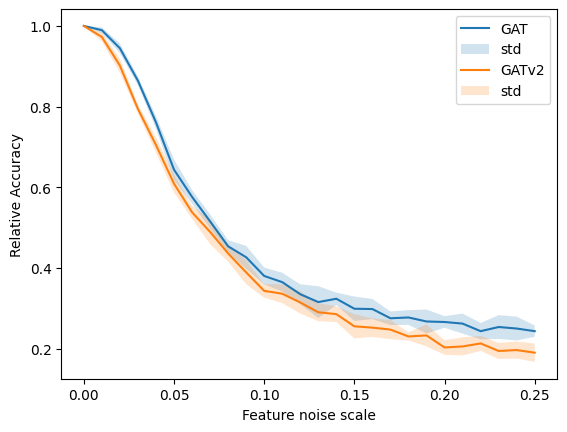

In [17]:
tests10 = np.array([tests_gat,tests_gatv2])
plot_n_tests(tests10, scale, titels=['GAT', 'GATv2'], ylabel = 'Relative Accuracy', xlabel = 'Feature noise scale')

In [26]:
print('GAT')
robustness_report(tests_gat)
print('\nGATv2')
robustness_report(tests_gatv2)

GAT
CV: 0.06 ± 0.036
AUC: 11.214 ± 0.14

GATv2
CV: 0.067 ± 0.036
AUC: 10.236 ± 0.116


## Adding edges

### CiteSeer

In [25]:
n = 10
num_added_edges, test_gat_citeseer = do_n_tests(test_edge_noise_robustness, gat_citeseer, data_citeseer, n=n)
num_added_edges, test_gatv2_citeseer = do_n_tests(test_edge_noise_robustness, gatv2_citeseer, data_citeseer, n=n)

KeyboardInterrupt: 

In [ ]:
results = np.array([test_gat_citeseer, test_gatv2_citeseer])
plot_n_tests(results, num_added_edges, titels=['GAT', 'GATv2'], ylabel = 'Relative Accuracy', xlabel = 'Number of added edges')

### Cora

In [19]:
n = 10
num_added_edges, acc_gat = do_n_tests(test_edge_noise_robustness, gat, data_cora, n=n)
_, acc_gatv2 = do_n_tests(test_edge_noise_robustness, gatv2, data_cora, n=n)

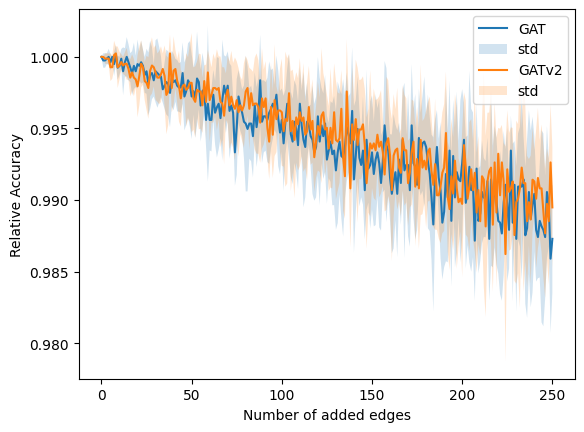

In [20]:
results = np.array([acc_gat, acc_gatv2])
plot_n_tests(results, num_added_edges, titels=['GAT', 'GATv2'], xlabel='Number of added edges', ylabel='Relative Accuracy')

In [21]:
print('GAT')
robustness_report(acc_gat)
print('\nGATv2')
robustness_report(acc_gatv2)

GAT
CV: 0.003 ± 0.001
AUC: 248.552 ± 0.058

GATv2
CV: 0.003 ± 0.001
AUC: 248.67 ± 0.065


## Removing edges

### CiteSeer

In [ ]:
n=10
num_removed_edges, acc_gat_citeseer = do_n_tests(test_edge_removal_robustness, gat_citeseer, data_citeseer, n=n)
num_removed_edges, acc_gatv2_citeseer = do_n_tests(test_edge_removal_robustness, gatv2_citeseer, data_citeseer, n=n)

In [ ]:
results = np.array([acc_gat_citeseer, acc_gatv2_citeseer])
plot_n_tests(results, num_removed_edges, titels=['GAT', 'GATv2'], xlabel='Number of removed edges', ylabel='Relative Accuracy')

### Cora

In [22]:
n=10
num_removed_edges, acc_gat_remove = do_n_tests(test_edge_noise_robustness, gat, data, n=n)
_, acc_gatv2_remove = do_n_tests(test_edge_noise_robustness, gatv2, data, n=n)

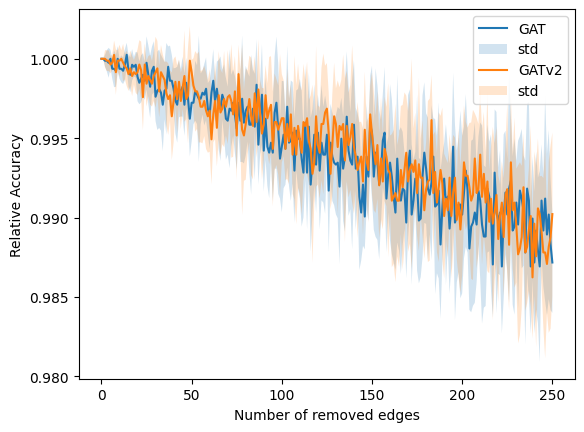

In [23]:
results = np.array([acc_gat_remove, acc_gatv2_remove])
plot_n_tests(results, num_removed_edges, titels=['GAT', 'GATv2'], xlabel='Number of removed edges', ylabel='Relative Accuracy')

In [24]:
print('GAT')
robustness_report(acc_gat_remove)
print('\nGATv2')
robustness_report(acc_gatv2_remove)

GAT
CV: 0.003 ± 0.001
AUC: 248.557 ± 0.08

GATv2
CV: 0.003 ± 0.001
AUC: 248.655 ± 0.054


## Setting some feature vector values to zero/constant


# Removing nodes

# Robustness metrics

Metrics we could try:
- RMSE (Prediction stability)
- Area under the curve

And for the variance based approaches
- Performance variance
- Coefficient of variation
- Linear degradation slope